# 1. 사용한 모듈

In [82]:
# pdf 관련 모듈
from pdfminer.pdfinterp import PDFResourceManager, process_pdf
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO
from io import open
from urllib.request import urlopen

# 자연어 처리 관련 모듈
from konlpy.tag import Mecab
import re
import os

# 자연어 처리된 값 계산과 관련된 모듈
import pandas as pd
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 시각화 관련 모듈
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from IPython.display import set_matplotlib_formats 
import seaborn as sns

# 2. PDF 읽기

#### - ESG의 대한 기업의 대한 정보를 가져오기 위해서 "지속 가능 경영 보고서"가 핵심

#### - "지속 가능 경영 보고서"는 주로 PDF 파일로 되어 있으므로 PDF 파일을 읽어올 수 있는 모듈이 필요

#### - 분석해야할 지속 가능 경영 보고서가 많기 때문에 함수를 만들자는 생각을 함

#### - 제가 가지고 있는 장비의 한계점으로 인해 각 환경, 사회, 지배구조에서 S 등급 이상 받은 하나의 기업의 지속 가능 경영 보고서를 가져와서 분석 </br> 
* (이 프로젝트에서는 어떤 식으로 분석하는지에 대한 방향만 제시하려고 하며, 실제 분석 내용은 별도로 제출한 PDF 파일로 따로 보셔야 됩니다.)

In [83]:
def read_pdf_file(pdfFile):
    pdfrm = PDFResourceManager()
    strio = StringIO()
    lapa = LAParams()
    device = TextConverter(pdfrm, strio, laparams = lapa)
    
    process_pdf(pdfrm, device, pdfFile)
    device.close()
    
    content = strio.getvalue()
    strio.close()
    return content

In [84]:
pdf_environment = open("./data/환경분야에서 S등급 받은 기업.pdf", "rb")
environment = read_pdf_file(pdf_environment)
pdf_environment.close() 

pdf_social = open("./data/사회분야에서 S등급 받은 기업.pdf", "rb")
social = read_pdf_file(pdf_social)
pdf_social.close() 

pdf_governance = open("./data/지배구조분야에서 S등급 받은 기업.pdf", "rb")
governance = read_pdf_file(pdf_governance)
pdf_governance.close() 

# 3. 토큰화

#### - 각 문서의 단어들을 토큰화 하여 e, s, g 리스트에 넣음

In [85]:
mecab = Mecab()
e = []
s = []
g = []

def word_token (esg, doc) :
    esg = []
    for token in mecab.pos(doc):
        esg.append(token)
    return esg

e = word_token(e, environment)
s = word_token(s, social)
g = word_token(g, governance)

# 4. 핵심키워드 추출하기

#### - n_stop 리스트는 불용어 처리를 위한 단어들을 입력하기 위해 만듬

#### - TF-IDF를 사용하여 이상한 단어들을 모두 불용어 리스트에 추가

* Environment에서 S등급 받은 문서의 키워드

In [86]:
e_stop = ["하이닉스", "발생", "관련", "공지", "력사", "상황", "현황", "누적"]

e_nodes = [t[0] for t in e]
e_vocab = [t[0] for t in e if t[0] not in e_stop if t[1] in ['NNG', 'NNP'] and len(t[0]) > 1]

print(e_nodes[:10])
print(e_vocab[:10])

['WE', 'DO', 'TECHNOLOGY', 'SK', 'hynix', 'Sustainability', 'Report', '2021', 'ENVIRONMENTAL', 'SOCIAL']
['메시지', '소개', '경영', '지속', '가능', '경영', '가치', '창출', '대응', '기후']


In [87]:
e_vocab = list(set(e_vocab))

e_vocab2idx = {e_vocab[i]:i for i in range(len(e_vocab))}
e_idx2vocab = {i:e_vocab[i] for i in range(len(e_vocab))}

e_vocab_len = len(e_vocab2idx)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
e_weighted_edge = np.zeros((e_vocab_len,e_vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
e_score = np.ones((e_vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
e_covered_coocurrences = []

for window_start in range(len(e_nodes) - window_size + 1):
    window = e_nodes[window_start:window_start+window_size]
    for i in range(window_size):
        for j in range(i+1, window_size):
            if window[i] in e_vocab and window[j] in e_vocab:
                index_i = window_start + i
                index_j = window_start + j

                if (index_i, index_j) not in e_covered_coocurrences:
                    e_weighted_edge[e_vocab2idx[window[i]]][e_vocab2idx[window[j]]] = 1
                    e_weighted_edge[e_vocab2idx[window[j]]][e_vocab2idx[window[i]]] = 1
                    e_covered_coocurrences.append((index_i, index_j))

for i in range(e_vocab_len):
    e_row_sum = e_weighted_edge[i].sum()
    e_weighted_edge[i] = e_weighted_edge[i]/e_row_sum if e_row_sum > 0 else 0

MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(MAX_ITERATIONS):
    e_prev_score = np.copy(e_score)

    for i in range(e_vocab_len):
        e_summation = 0
        for j in range(e_vocab_len):
            if e_weighted_edge[j][i] != 0:
                e_summation += e_weighted_edge[j][i] * e_prev_score[j]

        e_score[i] = (1 - d) * d * e_summation

    if np.sum(np.fabs(e_prev_score -  e_score)) <= threshold:
        break


e_sorted_index = np.flip(np.argsort(e_score), 0)

n = 50


print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(e_idx2vocab[e_sorted_index[i]])+" : " + str(e_score[e_sorted_index[i]]))


=== 핵심키워드 ===
반도체 : 5.9324652e-08
대응 : 5.461495e-08
경영 : 4.2152674e-08
구성원 : 3.5168934e-08
사회 : 3.493381e-08
개발 : 3.450724e-08
환경 : 3.3252153e-08
회의 : 3.0235988e-08
생산 : 2.9105335e-08
지원 : 2.7789667e-08
기술 : 2.7466381e-08
주요 : 2.67124e-08
운영 : 2.634215e-08
활동 : 2.6308422e-08
체계 : 2.5769893e-08
성장 : 2.418007e-08
목표 : 2.3727464e-08
채널 : 2.3331626e-08
이상 : 2.3050884e-08
신고 : 2.2279014e-08
보안 : 2.1815717e-08
성과 : 2.1574634e-08
휴가 : 2.0429336e-08
업무 : 2.0187981e-08
기업 : 2.006408e-08
추진 : 1.9646759e-08
사내 : 1.9481243e-08
전략 : 1.8930512e-08
보건 : 1.8836875e-08
지속 : 1.873617e-08
감염병 : 1.8430324e-08
관리 : 1.805851e-08
배출 : 1.7968159e-08
국내 : 1.7808267e-08
참조 : 1.7808267e-08
재이 : 1.7808267e-08
공시 : 1.7808267e-08
추가 : 1.7737166e-08
접촉 : 1.6902279e-08
고객 : 1.6720275e-08
건강 : 1.6445597e-08
선별 : 1.6424364e-08
사업 : 1.6206915e-08
비즈니스 : 1.6198864e-08
접근 : 1.545306e-08
기반 : 1.54193e-08
제조 : 1.5402302e-08
검사 : 1.5287574e-08
감염 : 1.5232237e-08
확인 : 1.50901e-08


* Social에서 S등급 받은 문서의 키워드

In [88]:
s_stop = ["에서", "삼성전자", "관련", "주요", "까지", "결과", "이슬람", "주니어"]

s_nodes = [t[0] for t in s]
s_vocab = [t[0] for t in s if t[0] not in s_stop if t[1] in ['NNG', 'NNP'] and len(t[0]) > 1]

print(s_nodes[:10])
print(s_vocab[:10])

['삼성전자', '지속', '가능', '경영', '보고서', '2021', 'A', 'JOURNEY', 'TOWARDS', 'A']
['지속', '가능', '경영', '보고서', '인사말', '회사', '소개', '글로벌', '네트워크', '지배']


In [89]:
s_vocab = list(set(s_vocab))

s_vocab2idx = {s_vocab[i]:i for i in range(len(s_vocab))}
s_idx2vocab = {i:s_vocab[i] for i in range(len(s_vocab))}

s_vocab_len = len(s_vocab2idx)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
s_weighted_edge = np.zeros((s_vocab_len,s_vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
s_score = np.ones((s_vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
s_covered_coocurrences = []

for window_start in range(len(s_nodes) - window_size + 1):
    window = s_nodes[window_start:window_start+window_size]
    for i in range(window_size):
        for j in range(i+1, window_size):
            if window[i] in s_vocab and window[j] in s_vocab:
                index_i = window_start + i
                index_j = window_start + j

                if (index_i, index_j) not in s_covered_coocurrences:
                    s_weighted_edge[s_vocab2idx[window[i]]][s_vocab2idx[window[j]]] = 1
                    s_weighted_edge[s_vocab2idx[window[j]]][s_vocab2idx[window[i]]] = 1
                    s_covered_coocurrences.append((index_i, index_j))

for i in range(s_vocab_len):
    s_row_sum = s_weighted_edge[i].sum()
    s_weighted_edge[i] = s_weighted_edge[i]/s_row_sum if s_row_sum > 0 else 0

MAX_ITERATIONS = 50
d = 0.85
threshold = 0.0001 #convergence threshold

for iter in range(MAX_ITERATIONS):
    s_prev_score = np.copy(s_score)

    for i in range(s_vocab_len):
        s_summation = 0
        for j in range(s_vocab_len):
            if s_weighted_edge[j][i] != 0:
                s_summation += s_weighted_edge[j][i] * s_prev_score[j]

        s_score[i] = (1 - d) * d * s_summation

    if np.sum(np.fabs(s_prev_score -  s_score)) <= threshold:
        break


s_sorted_index = np.flip(np.argsort(s_score), 0)

n = 50


print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(s_idx2vocab[s_sorted_index[i]])+" : " + str(s_score[s_sorted_index[i]]))


=== 핵심키워드 ===
관리 : 2.0964384e-08
교육 : 1.8573987e-08
제품 : 1.7559483e-08
임직원 : 1.5617356e-08
경영 : 1.553245e-08
지원 : 1.5338028e-08
환경 : 1.4725124e-08
협력 : 1.4176318e-08
사용 : 1.26657e-08
기준 : 1.2566616e-08
기술 : 1.24486e-08
사업장 : 1.2441527e-08
평가 : 1.20194015e-08
회사 : 1.1694649e-08
운영 : 1.161603e-08
글로벌 : 1.1209341e-08
활동 : 1.102425e-08
서비스 : 1.0952301e-08
개발 : 1.00480175e-08
개선 : 9.830927e-09
지역 : 9.518499e-09
인증 : 9.13363e-09
안전 : 9.10164e-09
사업 : 9.070432e-09
보안 : 8.715297e-09
시스템 : 8.678674e-09
삼성 : 8.60812e-09
정보 : 8.527298e-09
사회 : 8.515281e-09
보호 : 8.475669e-09
에너지 : 7.8979125e-09
현황 : 7.762227e-09
공정 : 7.640511e-09
비율 : 7.554833e-09
인권 : 7.332541e-09
전력 : 7.2616264e-09
센터 : 7.1984885e-09
확대 : 7.107242e-09
효율 : 6.9921082e-09
사내 : 6.938036e-09
제조 : 6.752345e-09
성과 : 6.6697186e-09
업무 : 6.665248e-09
기업 : 6.5447887e-09
감축 : 6.5286123e-09
반도체 : 6.4925785e-09
부문 : 6.2996697e-09
처리 : 6.2682974e-09
체계 : 6.0449388e-09
대비 : 6.035513e-09


* Governance에서 S등급 받은 문서의 키워드

In [90]:
g_stop = ["에서", "현대", "위해", "대상", "관련", "주요", "까지", "기준", "현황", "주니어", "원주민", "전고", "동안"]

g_nodes = [t[0] for t in g]
g_vocab = [t[0] for t in g if t[0] not in g_stop if t[1] in ['NNG', 'NNP'] and len(t[0]) > 1]

print(g_nodes[:10])
print(g_vocab[:10])

['Road', 'to', 'Sustainability', '2021', '현대', '자동차', '지속', '가능', '성', '보고서']
['자동차', '지속', '가능', '보고서', '회사', '개요', '실적', '전략', '전기', '자율']


In [91]:
g_vocab = list(set(g_vocab))

g_vocab2idx = {g_vocab[i]:i for i in range(len(g_vocab))}
g_idx2vocab = {i:g_vocab[i] for i in range(len(g_vocab))}

g_vocab_len = len(g_vocab2idx)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
g_weighted_edge = np.zeros((g_vocab_len,g_vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
g_score = np.ones((g_vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
g_covered_coocurrences = []

for window_start in range(len(g_nodes) - window_size + 1):
    window = g_nodes[window_start:window_start+window_size]
    for i in range(window_size):
        for j in range(i+1, window_size):
            if window[i] in g_vocab and window[j] in g_vocab:
                index_i = window_start + i
                index_j = window_start + j

                if (index_i, index_j) not in g_covered_coocurrences:
                    g_weighted_edge[g_vocab2idx[window[i]]][g_vocab2idx[window[j]]] = 1
                    g_weighted_edge[g_vocab2idx[window[j]]][g_vocab2idx[window[i]]] = 1
                    g_covered_coocurrences.append((index_i, index_j))

for i in range(g_vocab_len):
    g_row_sum = g_weighted_edge[i].sum()
    g_weighted_edge[i] = g_weighted_edge[i]/g_row_sum if g_row_sum > 0 else 0

MAX_ITERATIONS = 50
d = 0.85
threshold = 0.0001 #convergence threshold

for iter in range(MAX_ITERATIONS):
    g_prev_score = np.copy(g_score)

    for i in range(g_vocab_len):
        g_summation = 0
        for j in range(g_vocab_len):
            if g_weighted_edge[j][i] != 0:
                g_summation += g_weighted_edge[j][i] * g_prev_score[j]

        g_score[i] = (1 - d) * d * g_summation

    if np.sum(np.fabs(g_prev_score -  g_score)) <= threshold:
        break


g_sorted_index = np.flip(np.argsort(g_score), 0)

n = 50


print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(g_idx2vocab[g_sorted_index[i]])+" : " + str(g_score[g_sorted_index[i]]))


=== 핵심키워드 ===
차량 : 2.1575081e-08
서비스 : 2.1485654e-08
기술 : 2.0158405e-08
교육 : 1.9900247e-08
자동차 : 1.9347185e-08
관리 : 1.8803636e-08
환경 : 1.6292873e-08
지원 : 1.6058374e-08
안전 : 1.5388718e-08
시스템 : 1.5368776e-08
활동 : 1.5322284e-08
운영 : 1.4841733e-08
사업 : 1.4057952e-08
글로벌 : 1.3760841e-08
개선 : 1.314672e-08
고객 : 1.3012059e-08
개발 : 1.2678e-08
사회 : 1.2455419e-08
평가 : 1.216099e-08
경영 : 1.1986696e-08
판매 : 1.1653893e-08
지역 : 1.14363905e-08
생산 : 1.1035816e-08
국내 : 1.0879807e-08
수소 : 1.06146905e-08
시장 : 1.0444706e-08
에너지 : 1.0214279e-08
기업 : 1.0206085e-08
프로그램 : 1.01510755e-08
품질 : 9.984325e-09
임직원 : 9.964307e-09
기반 : 9.738521e-09
협력 : 9.369085e-09
정보 : 9.088122e-09
모빌리티 : 8.72326e-09
미래 : 8.577048e-09
데이터 : 8.412139e-09
해외 : 8.403598e-09
공장 : 8.164546e-09
친환경 : 8.089886e-09
확대 : 8.044275e-09
제도 : 7.807597e-09
강화 : 7.799693e-09
분야 : 7.748822e-09
추진 : 7.744096e-09
활용 : 7.661403e-09
제품 : 7.593173e-09
성장 : 7.4125817e-09
검증 : 7.364221e-09
사업장 : 7.2367334e-09


# 5. 시각화

#### - Word Cloud 

#### - Heat-Map

* Environment, Social, Governance 분야 순으로 Word Cloud

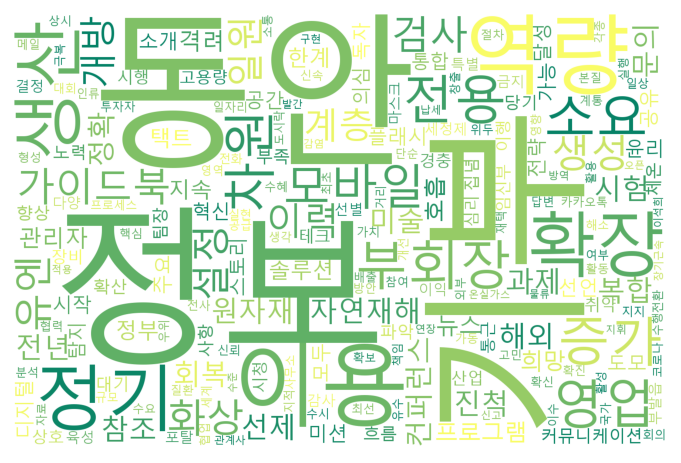

In [92]:
e_count = Counter(e_vocab)
e_words = dict(e_count.most_common())

matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "summer", 
                      width=1500, height=1000).generate_from_frequencies(e_words) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

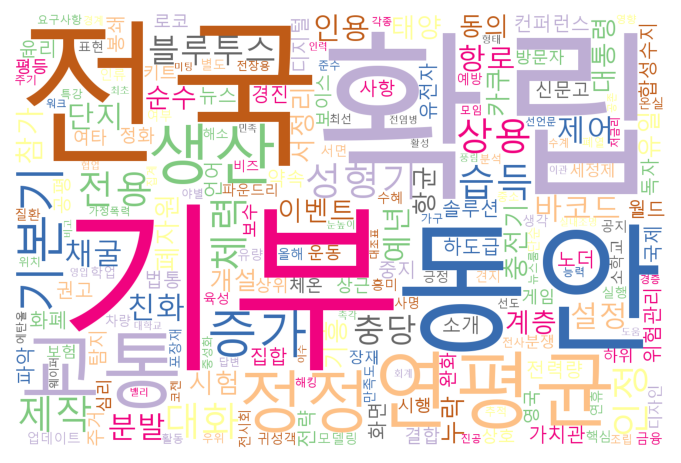

In [93]:
s_count = Counter(s_vocab)
s_words = dict(s_count.most_common())

matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(s_words) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

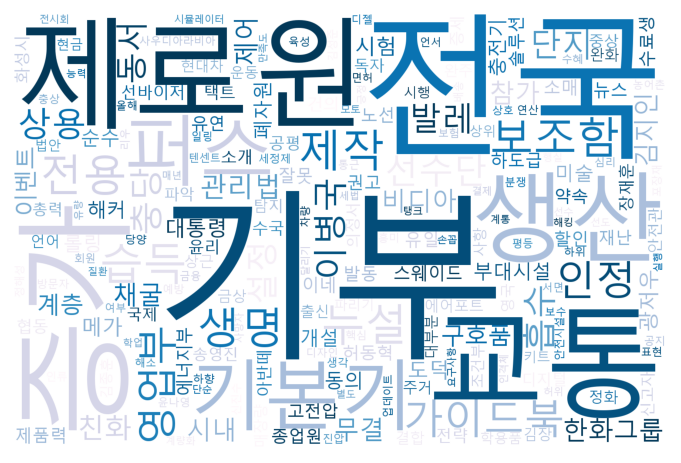

In [94]:
g_count = Counter(g_vocab)
g_words = dict(g_count.most_common())

matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "PuBu", 
                      width=1500, height=1000).generate_from_frequencies(g_words) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

* Heat-map 사전 준비 함수 

In [95]:
def calc_simiarlty_matrix(vectors):
    def consine_similarity(a,b):
        return dot(a,b)/(norm(a)*norm(b))
    
    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word, n_word))
    
    for i in range(n_word):
        for j in range(n_word):
            similarity_matrix[j, i] = consine_similarity(vectors[i], vectors[j]).round(4)

    return similarity_matrix

def visualize_similarity(similarity_matrix, label):
    mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rc('font', family='Malgun Gothic')
    ax = sns.heatmap(similarity_matrix, mask=mask, xticklabels=label, yticklabels=label,
                     annot=True, fmt=".2f", annot_kws={"size":8},cmap="coolwarm")

In [96]:
e_keyword = []
for i in range(0,15):
    e_keyword.append(str(e_idx2vocab[e_sorted_index[i]]))

n_topic = 3

e_tfidf_vect = TfidfVectorizer()
e_tfidf = e_tfidf_vect.fit_transform(e_keyword)
e_svd = TruncatedSVD(n_components=n_topic, n_iter=100)

e_U = e_svd.fit_transform(e_tfidf)
e_Vt = e_svd.components_
e_vocab = e_tfidf_vect.get_feature_names()

e_word_vectors = e_Vt.T
e_word_similarity_matrix = calc_simiarlty_matrix(e_word_vectors)

In [97]:
s_keyword = []
for i in range(0,15):
    s_keyword.append(str(s_idx2vocab[s_sorted_index[i]]))

n_topic = 3

s_tfidf_vect = TfidfVectorizer()
s_tfidf = s_tfidf_vect.fit_transform(s_keyword)
s_svd = TruncatedSVD(n_components=n_topic, n_iter=100)

s_U = s_svd.fit_transform(s_tfidf)
s_Vt = s_svd.components_
s_vocab = s_tfidf_vect.get_feature_names()

s_word_vectors = s_Vt.T
s_word_similarity_matrix = calc_simiarlty_matrix(s_word_vectors)

In [98]:
g_keyword = []
for i in range(0,15):
    g_keyword.append(str(g_idx2vocab[g_sorted_index[i]]))

n_topic = 3

g_tfidf_vect = TfidfVectorizer()
g_tfidf = g_tfidf_vect.fit_transform(g_keyword)
g_svd = TruncatedSVD(n_components=n_topic, n_iter=100)

g_U = g_svd.fit_transform(g_tfidf)
g_Vt = g_svd.components_
g_vocab = g_tfidf_vect.get_feature_names()

g_word_vectors = g_Vt.T
g_word_similarity_matrix = calc_simiarlty_matrix(g_word_vectors)

* Environment, Social, Governance 분야 순으로 Heat-map

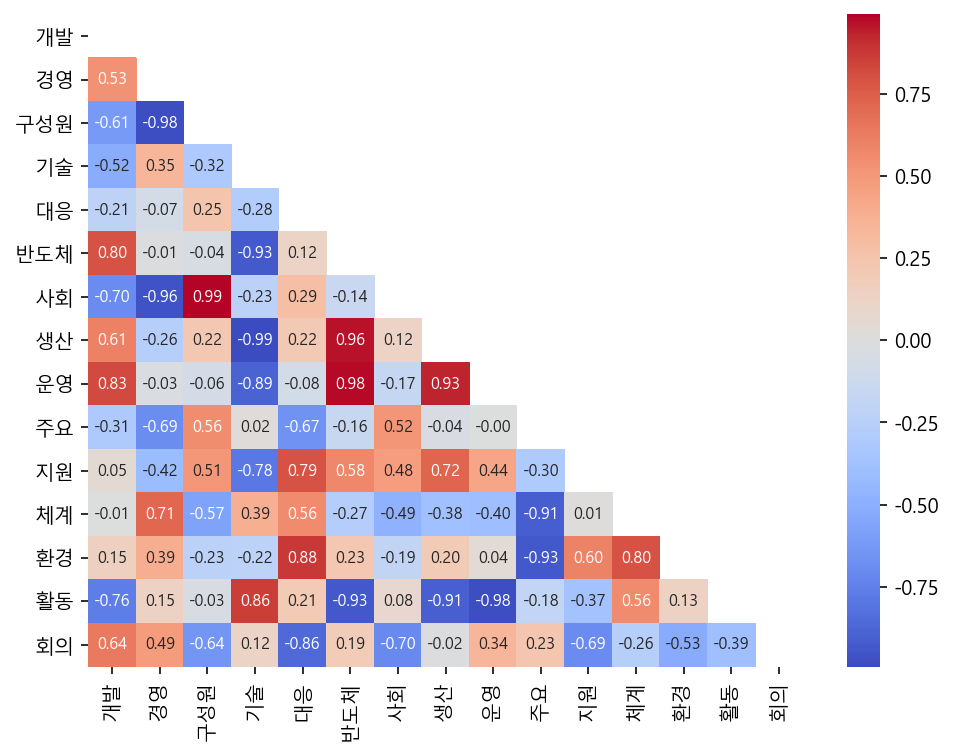

In [99]:
visualize_similarity(e_word_similarity_matrix, e_vocab)

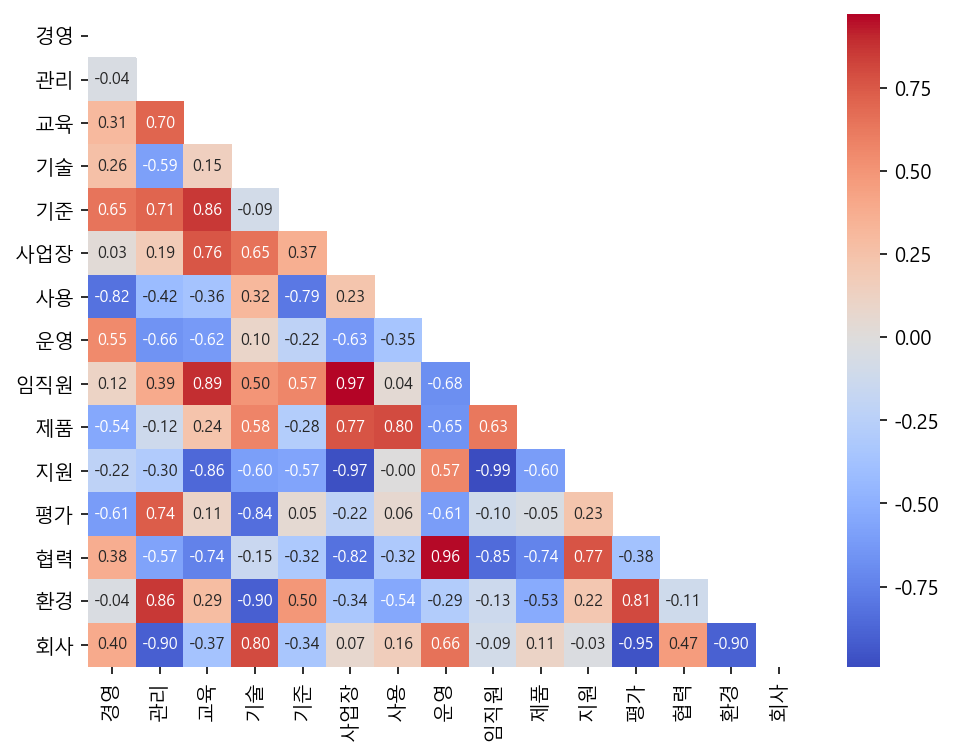

In [100]:
visualize_similarity(s_word_similarity_matrix, s_vocab)

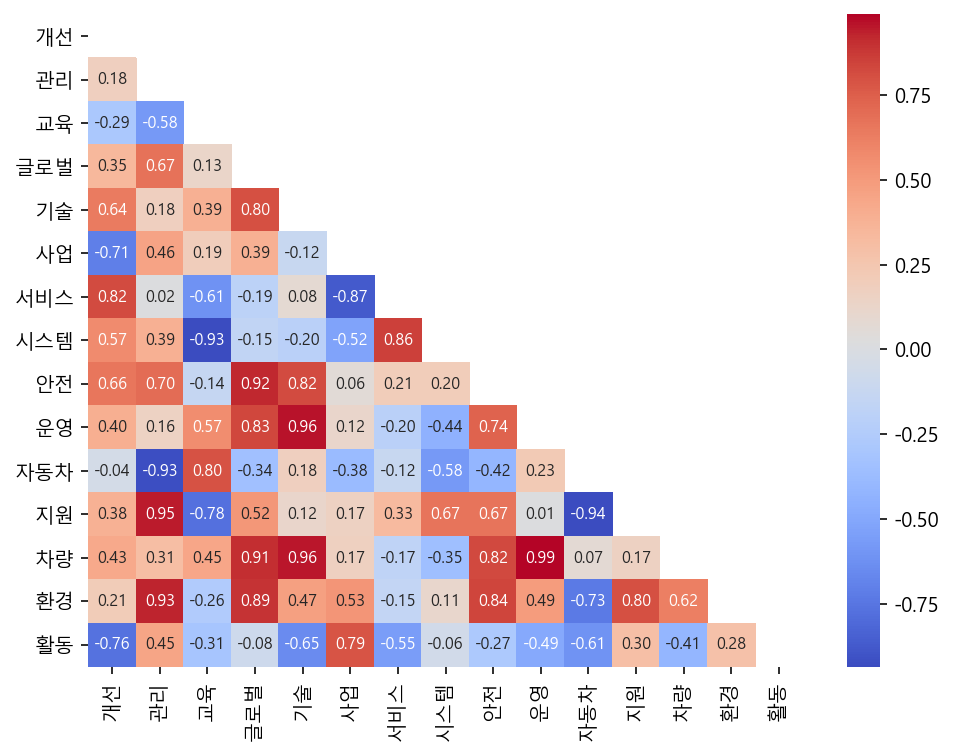

In [101]:
visualize_similarity(g_word_similarity_matrix, g_vocab)